In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn import metrics

In [2]:
''' Utility functions '''
def get_data(model_name, nctxt, mode, n, ubs, regime, context_style, dataset_name, indices, mepochs=1, prefix=''):
    dfa_list = []
    if nctxt == 0:
        nctxt = 1

    for i in indices:
        if mode == 'icl':
            dfa = pd.read_csv(f'../results/{dataset_name}/{prefix}/ubs{ubs}/nctxt{nctxt}/results_{dataset_name}_{model_name}_model{i}_{mode}_n{n}_mepochs{mepochs}_uepochs1_bs{ubs}_{context_style}_nctxt{nctxt}_{regime}.csv', index_col=False)

        else:
            print(f"Mode '{mode}' not supported")
            return None
        dfa_list.append(dfa)
    ind_mask_all = pd.read_csv(f"../finetuned_models/{dataset_name}_mask_epochs{mepochs}_unlearnbs{ubs}.csv", index_col=False).to_numpy()
    ind_mask_all = np.delete(ind_mask_all, 2, axis=1)
    return dfa_list, ind_mask_all

def get_losses(losses_ordered_forget, 
               losses_ordered_test, 
               ind_mask_all, 
               model_k, 
               bs=1):
    ph = []
    counter_forget = 0
    counter_test = 0
    for i in range(ind_mask_all.shape[0]):
        if ind_mask_all[i, model_k]:
            for j in range(bs):
                ph.append(losses_ordered_forget[counter_forget])
                counter_forget += 1
        else:
            for j in range(bs):
                ph.append(losses_ordered_test[counter_test])
                counter_test += 1

    return np.array(ph)

def get_scores(df_list_, ind_mask, indices, forget=None, test=None, forget_losses=None, test_losses=None):
    M = len(df_list_)
    scores = np.zeros((df_list_[0].shape[0]*2, M))

    
    for iter_j, m_idx in enumerate(indices):
        if m_idx >= 2:
            m_idx = m_idx - 1
        if forget_losses is not None and test_losses is not None:
            s = get_losses(losses_ordered_forget=forget_losses[iter_j], 
                          losses_ordered_test=test_losses[iter_j],
                          ind_mask_all=ind_mask, 
                          model_k=m_idx)
        else:
            s = get_losses(losses_ordered_forget=df_list_[iter_j][forget], 
                          losses_ordered_test=df_list_[iter_j][test],
                          ind_mask_all=ind_mask, 
                          model_k=m_idx)
            
        scores[:,iter_j] = s
    return scores

def split_scores(scores, ind_mask_all, min_keep=3, lrt=False, idx_t0=0):
    n_keep = min_keep - 1
    if lrt:
        n_keep = n_keep - 1
        M = scores.shape[1]
        mask_t0 = ind_mask_all[:, idx_t0]
        t0 = scores[:, idx_t0]
        other_inds = np.delete(range(M), idx_t0).tolist()
        ind_mask_all = ind_mask_all[:,other_inds]
        scores = scores[:, other_inds]
        
        maskin = ind_mask_all * 1
        maskout = (~ind_mask_all) * 1
        scores_in = scores * maskin
        scores_out = scores * maskout
        
        nzi = np.zeros(scores_in.shape[0], dtype=bool)
        non_zeros_in = np.where(np.sum(maskin, axis=1) > n_keep)[0]
        nzi[non_zeros_in] = True
        nzo = np.zeros(scores_out.shape[0], dtype=bool)
        non_zeros_out = np.where(np.sum(maskout, axis=1) > n_keep)[0]
        nzo[non_zeros_out] = True
        ind_keep = np.where(((nzi*1)*(nzo*1))!=0)[0]
        
        scores_in = scores_in[ind_keep]
        scores_out = scores_out[ind_keep]
        t0 = t0[ind_keep]
        mask_t0 = mask_t0[ind_keep]
        
        normalizer_in = np.count_nonzero(scores_in, axis=1)
        normalizer_out = np.count_nonzero(scores_out, axis=1)
        m_scores_unlearned = np.sum(scores_in, axis=1)/normalizer_in
        m_scores_retained = np.sum(scores_out, axis=1)/normalizer_out
        return m_scores_unlearned, m_scores_retained, t0, mask_t0
    else:
        maskin = ind_mask_all * 1
        maskout = (~ind_mask_all) * 1
        scores_in = scores * maskin
        scores_out = scores * maskout
        
        nzi = np.zeros(scores_in.shape[0], dtype=bool)
        non_zeros_in = np.where(np.sum(maskin, axis=1)>n_keep)[0]
        nzi[non_zeros_in] = True
        nzo = np.zeros(scores_out.shape[0], dtype=bool)
        non_zeros_out = np.where(np.sum(maskout, axis=1)>n_keep)[0]
        nzo[non_zeros_out] = True
        ind_keep = np.where(((nzi*1)*(nzo*1))!=0)[0]
        
        scores_in = scores_in[ind_keep]
        scores_out = scores_out[ind_keep]
        
        normalizer_in = np.count_nonzero(scores_in, axis=1)
        normalizer_out = np.count_nonzero(scores_out, axis=1)
        m_scores_unlearned = np.sum(scores_in, axis=1)/normalizer_in
        m_scores_retained = np.sum(scores_out, axis=1)/normalizer_out
        return m_scores_unlearned, m_scores_retained
    
def get_lrt_scores(t0, mask_t0, m_scores_unlearn_lrt, m_scores_holdout_lrt):
    mean_scores_unlearn_lrt = np.mean(m_scores_unlearn_lrt)
    mean_scores_holdout_lrt = np.mean(m_scores_holdout_lrt)
    std_unlearn = np.std(m_scores_unlearn_lrt)
    std_holdout = np.std(m_scores_holdout_lrt)

    pr_in_lrt = - norm.logpdf(t0, m_scores_unlearn_lrt, std_unlearn+1e-15)
    pr_out_lrt = - norm.logpdf(t0, m_scores_holdout_lrt, std_holdout+1e-15)
    scores_lrt = pr_in_lrt - pr_out_lrt 
    m_scores_unlearn_lrt = scores_lrt[mask_t0]
    m_scores_holdout_lrt = scores_lrt[~mask_t0]
    return m_scores_unlearn_lrt, m_scores_holdout_lrt

def compute_curve(train_scores: np.array, test_scores: np.array, pos_label=1):
    y = np.r_[np.ones(np.shape(train_scores)[0]), np.zeros(np.shape(test_scores)[0])]
    fs, ts, thresholds = metrics.roc_curve(y, np.r_[train_scores, test_scores], pos_label=pos_label)
    return ts, fs

In [3]:

def lira_forget_all_points(indices, n, ubs, model_name, datasets, iters, ctxt_lengths, regime, mepochs=1, prefix=''):
    mean_fpr = np.linspace(0, 1, 10000)
    overall_results = {}
    
    for dataset_name in datasets:
        min_keep_results = {}
        
        for min_keep in [2, 5]:
            results = {
                'metric_icl': {str(nctxt): {'tprs': [], 'aucs': []} for nctxt in ctxt_lengths},
                'metric_base': {'tprs': [], 'aucs': []},
                'metric_ga': {'tprs': [], 'aucs': []}
            }
            
            for idx_t0 in range(iters):
                for i, nctxt in enumerate(ctxt_lengths):
                    context_style = 'only_forget_points' if nctxt == 0 else 'vary'
                    dflist, ind_mask_all = get_data(
                        model_name=model_name,
                        nctxt=nctxt, mode='icl', n=n, ubs=ubs, 
                        context_style=context_style, regime=regime,
                        dataset_name=dataset_name, indices=indices, mepochs=mepochs, prefix=prefix
                    )

                    all_unlearned_icl = []
                    all_retained_icl = []
                    all_unlearned_base = []
                    all_retained_base = []


                    for num_point in range(ubs): # we loop over the number of points in the forget set (there are ubs points)
                        forget_losses_icl_point = []
                        test_losses_icl_point = []
                        forget_losses_base_point = []
                        test_losses_base_point = []

                        
                        for iter_j in range(len(dflist)):
                            forget_losses_icl_point.append(dflist[iter_j][f'losses_icl_forget_{num_point}'])
                            test_losses_icl_point.append(dflist[iter_j][f'losses_icl_test_{num_point}'])

                            forget_losses_base_point.append(dflist[iter_j][f'losses_base_forget_{num_point}'])
                            test_losses_base_point.append(dflist[iter_j][f'losses_base_test_{num_point}'])

                        # Compute scores with combined losses
                        scores_icl = get_scores(
                            dflist, 
                            ind_mask_all, 
                            indices, 
                            forget_losses=forget_losses_icl_point,
                            test_losses=test_losses_icl_point
                        )
                        
                        m_scores_unlearned_lrt_icl, m_scores_retained_lrt_icl, t0_icl, mask_t0_icl = split_scores(
                            scores_icl, ind_mask_all, min_keep=min_keep, lrt=True, idx_t0=idx_t0
                        )
                        m_scores_unlearned_lrt_icl, m_scores_retained_lrt_icl = get_lrt_scores(
                            t0_icl, mask_t0_icl, m_scores_unlearned_lrt_icl, m_scores_retained_lrt_icl
                        )

                        all_unlearned_icl.extend(m_scores_unlearned_lrt_icl)
                        all_retained_icl.extend(m_scores_retained_lrt_icl)


                        ts_icl, fs_icl = compute_curve(-m_scores_unlearned_lrt_icl, -m_scores_retained_lrt_icl, pos_label=1)
                        auc_icl = np.round(metrics.auc(fs_icl, ts_icl), 2)
                        interp_tpr_icl = np.interp(mean_fpr, fs_icl, ts_icl)
                        interp_tpr_icl[0] = 0.0
                 

                        if i == 0:
                            # Baseline with combined losses
                            scores_base = get_scores(
                                dflist, 
                                ind_mask_all, 
                                indices, 
                                forget_losses=forget_losses_base_point,
                                test_losses=test_losses_base_point
                            )

                            
                            m_scores_forget_lrt_base, m_scores_retained_lrt_base, t0_base, mask_t0_base = split_scores(
                                scores_base, ind_mask_all, min_keep=min_keep, lrt=True, idx_t0=idx_t0
                            )
                            m_scores_forget_lrt_base, m_scores_retained_lrt_base = get_lrt_scores(
                                t0_base, mask_t0_base, m_scores_forget_lrt_base, m_scores_retained_lrt_base
                            )

                            all_unlearned_base.extend(m_scores_forget_lrt_base)
                            all_retained_base.extend(m_scores_retained_lrt_base)

                            ts_base, fs_base = compute_curve(-m_scores_forget_lrt_base, -m_scores_retained_lrt_base, pos_label=1)
                            auc_base = np.round(metrics.auc(fs_base, ts_base), 2)
                            interp_tpr_base = np.interp(mean_fpr, fs_base, ts_base)
                            interp_tpr_base[0] = 0.0
                            

                    # ROC curves for all points combined
                    ts_icl, fs_icl = compute_curve(-np.array(all_unlearned_icl), -np.array(all_retained_icl), pos_label=1)
                    auc_icl = np.round(metrics.auc(fs_icl, ts_icl), 2)
                    interp_tpr_icl = np.interp(mean_fpr, fs_icl, ts_icl)
                    interp_tpr_icl[0] = 0.0
                    results[f'metric_icl'][str(nctxt)]['tprs'].append(interp_tpr_icl)
                    results[f'metric_icl'][str(nctxt)]['aucs'].append(auc_icl)

                    if i == 0:
                        ts_base, fs_base = compute_curve(-np.array(all_unlearned_base), -np.array(all_retained_base), pos_label=1)
                        auc_base = np.round(metrics.auc(fs_base, ts_base), 2)
                        interp_tpr_base = np.interp(mean_fpr, fs_base, ts_base)
                        interp_tpr_base[0] = 0.0
                        results['metric_base']['tprs'].append(interp_tpr_base)
                        results['metric_base']['aucs'].append(auc_base)


            min_keep_results[f'min_keep{min_keep}'] = results
        overall_results[dataset_name] = min_keep_results

    return overall_results

Using prefix: eval_skip_cancel_decode_ctxts
Running LiRA forget analysis for ubs = 1...


ubs 1 : icl : tpr at fpr 0.01 with nctxt 6: 0.011633235456937487
ubs 1 : base : tpr at fpr 0.01 : 0.03206838923805691


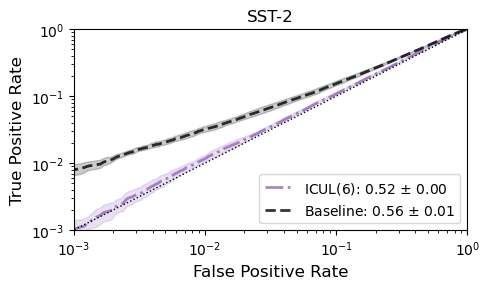

Finished LiRA forget.


In [4]:

if __name__ == "__main__":
    # Setup
    mepochs = 3
    datasets = ['sst2'] # ['amazon_polarity', 'sst2', 'ag_news']
    regime = 'lfmfirst-k'
    mean_fpr = np.linspace(0, 1, 10000)
    model_name = 'OLMo-2-0425-1B' #'OLMo-2-0425-1B' 'bloom-1b1'
    indices = [0, 1, 3, 4, 5, 6, 7, 8, 9]
    iters = len(indices)
    n = 12500

    list_ubs = [1] #, 10, 20] # 10, 20]


    tpr_at_fpr_001 = {ubs: None for ubs in list_ubs}
    fpr_target = 0.01

    for prefix in ['eval_skip_cancel_decode_ctxts']:
        print(f'Using prefix: {prefix}')
        for ubs in list_ubs:

            print(f"Running LiRA forget analysis for ubs = {ubs}...")
            ctxt_lengths = [2, 4, 6]

            if (datasets[0] == 'amazon_polarity' and ubs == 10):
                ctxt_lengths = [2, 6]
            elif datasets[0] == 'sst2' or (datasets[0] == 'ag_news' and ubs == 20):
                ctxt_lengths = [6]

            tpr_at_fpr_001[ubs] = {'base': {num_point: None for num_point in range(ubs)}, 
                                    **{f'icl_{nctxt}': {num_point: None for num_point in range(ubs)} for nctxt in ctxt_lengths}}

            all_results = lira_forget_all_points(
                indices, n, ubs, model_name, datasets, iters, ctxt_lengths, regime, mepochs=mepochs, prefix=prefix
            )

            # Plotting
            if datasets[0] == 'sst2':
                titles = ['SST-2']
            elif datasets[0] == 'amazon_polarity':
                titles = ['Amazon Polarity']
            elif datasets[0] == 'ag_news':
                titles = ['AG News']
            else:
                titles = ['Unknown Dataset']

            savingtype = 'png'
            min_keep = '2'

            color_map = {
                0: 'tab:blue',
                2: 'tab:orange',
                4: 'tab:red',
                6: 'tab:purple',
                8: 'tab:cyan',
                10: 'tab:pink',
                16: 'tab:green',
                40: 'tab:brown'
            }

            fig, axs = plt.subplots(1, len(datasets), figsize=(len(datasets)*5, 3))
            if len(datasets) == 1:
                axs = [axs]
                
            for id_data, dataset_name in enumerate(datasets):
                results = all_results[dataset_name][f'min_keep{min_keep}']

                # ICUL
                
                for i, nctxt in enumerate(ctxt_lengths):
                    tprs_u = np.array(results[f'metric_icl'][f'{nctxt}']['tprs']).T
                    aucs_u = np.array(results[f'metric_icl'][f'{nctxt}']['aucs']).T
                    mean_tpr_u = np.mean(tprs_u, axis=1)
                    std_tpr_u = np.std(tprs_u, axis=1)
                    mean_tpr_u[-1] = 1.0
                    mean_auc_u = np.mean(aucs_u).round(2)
                    std_auc_u = np.std(aucs_u).round(2)


                    line_color = color_map.get(nctxt, 'tab:green')
                    axs[id_data].loglog(mean_fpr, mean_tpr_u,
                                    label=r"ICUL(%s): %0.2f $\pm$ %0.2f" % (nctxt, mean_auc_u, std_auc_u), 
                                    lw=2, alpha=0.8, linestyle='dashdot', color=line_color)
                    tprs_upper_u = mean_tpr_u + std_tpr_u
                    tprs_lower_u = mean_tpr_u - std_tpr_u
                    axs[id_data].fill_between(mean_fpr, tprs_lower_u, tprs_upper_u, alpha=0.2, color=line_color)

                    # tpr at fpr = 0.001
                    fpr_u_idx = np.where(mean_fpr >= fpr_target)[0][0]
                    tpr_u_at_fpr_001 = mean_tpr_u[fpr_u_idx]
                    # upper and lower bounds
                    tprs_upper_u_at_fpr_001 = tprs_upper_u[fpr_u_idx]
                    tprs_lower_u_at_fpr_001 = tprs_lower_u[fpr_u_idx]
                    tpr_at_fpr_001[ubs][f'icl_{nctxt}'] = (float(tpr_u_at_fpr_001), float(tprs_upper_u_at_fpr_001), float(tprs_lower_u_at_fpr_001))
                    print(f"ubs {ubs} : icl : tpr at fpr {fpr_target} with nctxt {nctxt}: {tpr_u_at_fpr_001}")

                
                # Base

                tprs_b = np.array(results['metric_base']['tprs']).T
                aucs_b = np.array(results['metric_base']['aucs']).T
                mean_tpr_b = np.mean(tprs_b, axis=1)
                std_tpr_b = np.std(tprs_b, axis=1)
                mean_tpr_b[-1] = 1.0
                mean_auc_b = np.mean(aucs_b).round(2)
                std_auc_b = np.std(aucs_b).round(2)
                tprs_upper_b = np.minimum(mean_tpr_b + std_tpr_b, 1)
                tprs_lower_b = np.maximum(mean_tpr_b - std_tpr_b, 0)


                # tpr at fpr = 0.01
                fpr_b_idx = np.where(mean_fpr >= fpr_target)[0][0]
                tpr_b_at_fpr_001 = mean_tpr_b[fpr_b_idx]
                tprs_upper_b_at_fpr_001 = tprs_upper_b[fpr_b_idx]
                tprs_lower_b_at_fpr_001 = tprs_lower_b[fpr_b_idx]
                tpr_at_fpr_001[ubs]['base'] = (float(tpr_b_at_fpr_001), float(tprs_upper_b_at_fpr_001), float(tprs_lower_b_at_fpr_001))
                print(f"ubs {ubs} : base : tpr at fpr {fpr_target} : {tpr_b_at_fpr_001}")


                
                axs[id_data].loglog(mean_fpr, mean_tpr_b, 
                                label=r"Baseline: %0.2f $\pm$ %0.2f" % (mean_auc_b, std_auc_b),
                                lw=2, alpha=0.8, linestyle='dashed', color='black')
                axs[id_data].fill_between(mean_fpr, tprs_lower_b, tprs_upper_b, alpha=0.2, color='black')
                axs[id_data].plot([0,1], [0,1], linestyle='dotted', color='black', lw=1.0)

                axs[id_data].legend(loc=4)
                axs[id_data].set_xlabel('False Positive Rate', fontsize=12)
                axs[id_data].set_ylabel('True Positive Rate', fontsize=12)
                axs[id_data].set_xlim([0.001, 1])
                axs[id_data].set_ylim([0.001, 1])
                axs[id_data].set_title(titles[id_data])
                
            plt.tight_layout()
            plt.savefig(f'results_ubs{ubs}/{dataset_name}_model{model_name}_mepochs{mepochs}_lira_forget_all_points.{savingtype}')
            plt.show()

        # write tpr_at_fpr_001 to a csv file
        tpr_at_fpr_001_df = pd.DataFrame(tpr_at_fpr_001).T
        # tpr_at_fpr_001_df.to_csv(f'results_tprs/{dataset_name}_{list_ubs}_tpr_at_fpr_001_lira_forget.csv')

        print("Finished LiRA forget.")